**Srayan Gangopadhyay**
*4th June 2020*

# Implementing vector fields

In [1]:
%matplotlib inline

^ Replace `inline` with `notebook` for an interactive plot.

Integrating... Done.
Exported data to  21-10-59_data.csv

 Parameter            Value
-------------  -----------
Max. distance  0.753035
Avg. distance  0.351935
Max. speed     5.58379e+06
Avg. speed     3.7886e+06


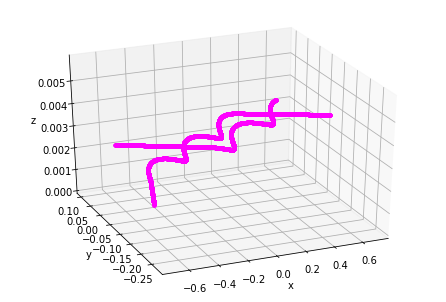

In [2]:
"""
Implementing vector fields
Srayan Gangopadhyay
2020-06-04
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML, display  # show anim. in ntbk
from tabulate import tabulate  # pretty text output
from datetime import datetime  # timestamp for output files

# PARAMETERS
r0 = [-0.4, 0, 0]  # initial position
v0 = [8e5, 8e5, 1e4]  # initial velocity
q, m = 1.6e-19, 1.67e-27  # charge, mass
h = 1e-10  # step size
end = h * 6000  # t-value to stop integration
size = [1.5,10,10]  # simulation dimensions
anim = False  # switch animation on/off

def B_field(r):
    """Returns the components of the magnetic
    field, given a 3D position vector."""
    if -0.35 <= r[0] <= 0.35:
        return [0,0,0.8]
    else:
        return [0,0,0]

def E_field(r):
    """Returns the components of the electric
    field, given a 3D position vector."""
    if -0.35 <= r[0] <= 0.35:
        return [0, 2.5e6, 0]
    else:
        return [0,0,0]

def lorentz(r, vel, E, B):
    """The Lorentz force equation. Returns
    acceleration of particle given its
    position, velocity, E field
    function, and B field function."""
    return (q/m)*(E(r) + np.cross(vel, B(r)))

# RUNGE-KUTTA INTEGRATOR
def rk4(func, init1, init2, h, end):
    """Takes the RHS of a 2nd-order ODE with initial conditions,
    step size and end point, and integrates using the 4th-order
    Runge-Kutta algorithm. Returns solution in an array.

    r'' = f(t, r, v) where v = r'

    func: the function to be integrated
    init1: value of r at t=0
    init2: value of v at t=0
    h: step size
    end: t-value to stop integrating
    """

    steps = int(end/h)  # number of steps
    r = np.zeros((3, steps))  # empty matrix for solution
    v = np.zeros((3, steps))
    r[:,0] = init1  # inserting initial value
    v[:,0] = init2

    for i in range(0, steps-1):
        k1r = h * v[:,i]
        k1v = h * func(r[:,i], v[:,i], E_field, B_field)
        k2r = h * (v[:,i] + 0.5*k1v)
        k2v = h * func(r[:,i], v[:,i] + 0.5*k1v, E_field, B_field)
        k3r = h * (v[:,i] + 0.5*k2v)
        k3v = h * func(r[:,i], v[:,i] + 0.5*k2v, E_field, B_field)
        k4r = h * (v[:,i] + k3v)
        k4v = h * func(r[:,i], v[:,i] + k3v, E_field, B_field)
        new_r = r[:,i] + (k1r + 2*k2r + 2*k3r + k4r) / 6
        new_v = v[:,i] + (k1v + 2*k2v + 2*k3v + k4v) / 6
        
        if (new_r[0] < size[0]*-0.5):  # stop particle leaving box
            new_r[0] += size[0]  
        if (new_r[0] >= size[0]*0.5):
            new_r[0] -= size[0]
            
        if (new_r[1] < size[1]*-0.5):
            new_r[1] += size[1]
        if (new_r[1] >= size[1]*0.5):
            new_r[1] -= size[1]
            
        if (new_r[2] < size[2]*-0.5):
            new_r[2] += size[2]
        if (new_r[2] >= size[2]*0.5):
            new_r[2] -= size[2]
            
        r[:,i+1] = new_r
        v[:,i+1] = new_v
    return r, v

print("Integrating... ", end='')
r, v = rk4(lorentz, r0, v0, h, end)  # call the integrator
print('Done.')

# calculate moduli of vectors
distances = np.linalg.norm(r, axis=0)
speeds = np.linalg.norm(v, axis=0)

# EXPORTING DATA TO .CSV FILE
filename = datetime.now().strftime('%H-%M-%S') + "_data.csv"  # for unique filename
with open(filename, 'a') as f:
    np.savetxt(f, r, delimiter=",")
    np.savetxt(f, v, delimiter=",")
    np.savetxt(f, distances, delimiter=",")
    np.savetxt(f, speeds, delimiter=",")
print("Exported data to ",filename)

fig = plt.figure()
ax = Axes3D(fig)

def animate(i):
    j = 100*i  # to skip frames and change animation speed
    ax.plot3D(r[0, :j], r[1, :j], r[2, :j], '.', color='magenta')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, -113)  # change viewing angle
ax.set_xlim3d(np.amin(r[0]), np.amax(r[0]))  # auto-scale axes
ax.set_ylim3d(np.amin(r[1]), np.amax(r[1]))
ax.set_zlim3d(np.amin(r[2]), np.amax(r[2]))

if not anim:
    ax.plot3D(r[0], r[1], r[2], '.', color='magenta')
    plt.show
else:
    print("Animating - this may take a while... ", end='')
    animation = animation.FuncAnimation(fig, animate, 
                                        frames=75, interval=50, blit=False, repeat=False)
    print("Done.")
    display(HTML(animation.to_html5_video()))

print("\n",tabulate([['Max. distance', np.amax(distances)], 
                     ['Avg. distance', np.mean(distances)], 
                     ['Max. speed', np.amax(speeds)], 
                     ['Avg. speed', np.mean(speeds)]], 
                    headers=['Parameter', 'Value']))